In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from os import path

# Setting up constants

In [83]:
sns.set(style="ticks", font_scale=1.5, palette="pastel") # font="Liberation Sans", 

RENDER = False # Change this if you want to save the final figures instead of just displaying them
FIG_DIR = "../drawings"
RUN_DIR = "../debug2"

# Helper functions
def render(outpath):
    if RENDER:
        print("Rendering image to " + path.join(FIG_DIR, outpath))
        plt.savefig(path.join(FIG_DIR, outpath), dpi=300, bbox_inches="tight")
    else:
        print("Not rendering image")
    
def print_sep(sep_char="*", sep_num=40):
    print(sep_char*sep_num)

# Training curves

Not rendering image


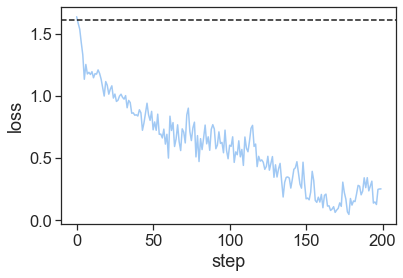

In [84]:
def plot_training_curve(df, metric="loss", outpath="seq2seq/training_loss.png"):
    ax = sns.lineplot(data=df, x="step", y=metric, units="seed", estimator=None)
    ax.axhline(-np.log(1/5), linestyle="--", color="k")
    render(outpath)

df = pd.read_csv(f"{RUN_DIR}/train-loss.csv")
plot_training_curve(df)

# Visually compare listener distributions

In [99]:
alts = np.load(f"{RUN_DIR}/alternatives.npy")
L_alt = np.load(f"{RUN_DIR}/L_alt.npy")
L_alt_greedy = np.load(f"{RUN_DIR}/L_alt_greedy.npy")
L_alt_random = np.load(f"{RUN_DIR}/L_alt_random.npy")
L0 = np.load(f"{RUN_DIR}/L_0.npy")
L1 = np.load(f"{RUN_DIR}/L_1.npy")
S0 = np.load(f"{RUN_DIR}/S_0.npy")
S1 = np.load(f"{RUN_DIR}/S_1.npy")
U = np.load(f"{RUN_DIR}/U.npy")
H = np.load(f"{RUN_DIR}/H.npy")
M = np.load(f"{RUN_DIR}/M.npy")

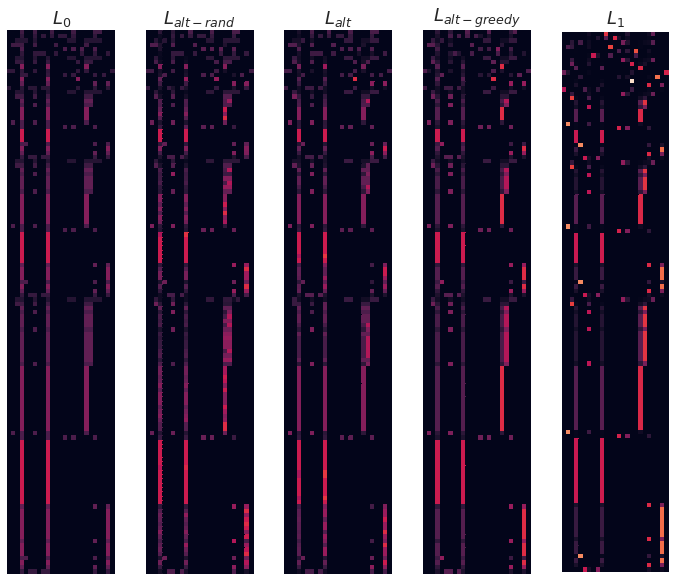

In [108]:
def plot_listeners(ls):
    fig, axes = plt.subplots(nrows=1, ncols=len(ls), figsize=(12,10))
    titles = ["$L_0$", "$L_{alt-rand}$", "$L_{alt}$", "$L_{alt-greedy}$", "$L_1$"]
    for i, mat in enumerate(ls):
        ax = axes[i]
        ax = sns.heatmap(
            mat, ax=ax, vmin=0, vmax=1, square=True, cbar=False, #(i==len(ls)-1), 
            xticklabels=[], yticklabels=[]
        )
        ax.set_title(titles[i])
    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
#         if i == 0:
#             ax.set_yticklabels(U)
#         else:
#             ax.set_yticklabels([])

plot_listeners([L0, L_alt_random, L_alt, L_alt_greedy, L1])

# Inspect generated alternatives

In [98]:
def table_header():
    th_style = "text-align:center"
    header = f"""<tr>
    <th style='{th_style}'>u</th>
    <th style='{th_style}'>compatible programs</th>
    <th style='{th_style}'>alt</th>
    <th style='{th_style}'>argmax S1(u|*)</th>
    <th style='{th_style}'>argmax Lalt(*|u)</th>
    <th style='{th_style}'>argmax L1(*|u)</th>
</tr>"""
    return header

def table_row(u, hs, alt, s, lalt, l1):
    td_style = "padding:0 30px 0 0;text-align:left"
    row = f"""<tr>
    <td style='{td_style}'>{u}</td>
    <td style='{td_style}'>{' --- '.join(hs)}</td>
    <td style='{td_style}'>{alt}</td> 
    <td style='{td_style}'>{s}</td> 
    <td style='{td_style+(";color:green;" if lalt==s else ";color:red;")}'>{lalt}</td> 
    <td style='{td_style+(";color:green;" if l1==s else ";color:red;")}'>{l1}</td> 
</tr>"""
    return row

def generate_table():
    alt_strs = [U[a_id][0] for a_id in alts]
    rows = []
    for i, u in enumerate(U):
        # get the meanings that are under consideration by L0
        row = L0[i]
        hs = H[row!=0]
        s = H[np.argmax(S1[i])]
        lalt = H[np.argmax(L_alt[i])]
        l1 = H[np.argmax(L1[i])]
        rows.append(table_row(u, hs, alt_strs[i], s, lalt, l1))
    rows = "\n".join(rows)
    style = "<style>tr:nth-child(even) {background-color: #f2f2f2;}</style>"
    table = f"{style}<table style='margin-left:auto;margin-right:auto'>{table_header()}{rows}</table>"
    return table

def write_to_file(s, f):
    with open(f, "w") as fp:
        fp.write(s)

table_html = generate_table()
write_to_file(table_html, f"{RUN_DIR}/alternatives.html")